# Telco Customer Churn

Welcome to my mini-project analysing the Telco Customer Churn dataset from the Kaggle website.

This notebook is a work in progress and will be updated periodically.

In [62]:
#Import required libraries
import pandas as pd
import numpy as np
from math import sqrt
from datetime import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython.display import Image  
import pydotplus

from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from io import StringIO
import warnings

In [2]:
#Read csv file into dataframe and display head
customer_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
customer_data.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   
7  No phone service             DSL            Yes  ...               No   
8               Yes     Fiber optic             No  ...              Yes   
9                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   
7          No          No              No  Month-to-month               No   
8         Yes         Yes             Yes  Month-to-month              Yes   
9          No          No              No        One year               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  
7               Mailed check          29.75         301.9    No  
8           Electronic check         104.80       3046.05   Yes  
9  Bank transfer (automatic)          56.15       3487.95    No  

[10 rows x 21 columns]

In [3]:
#Display dataframe characteristics
print('Rows: ', customer_data.shape[0])
print('Columns: ', customer_data.shape[1])

df_info = pd.DataFrame({'Null values': customer_data.isnull().sum().values, 
                        'Unique values': customer_data.nunique(), 
                        'Data type': customer_data.dtypes})
df_info.columns.names = ['Feature']
print('\n', df_info)

Rows:  7043
Columns:  21

 Feature           Null values  Unique values Data type
customerID                  0           7043    object
gender                      0              2    object
SeniorCitizen               0              2     int64
Partner                     0              2    object
Dependents                  0              2    object
tenure                      0             73     int64
PhoneService                0              2    object
MultipleLines               0              3    object
InternetService             0              3    object
OnlineSecurity              0              3    object
OnlineBackup                0              3    object
DeviceProtection            0              3    object
TechSupport                 0              3    object
StreamingTV                 0              3    object
StreamingMovies             0              3    object
Contract                    0              3    object
PaperlessBilling            0         

In [4]:
#Convert 'TotalCharges' column values to float and check for nulls again
customer_data['TotalCharges'] = pd.to_numeric(customer_data['TotalCharges'], errors= 'coerce')

df_info = pd.DataFrame({'Null values': customer_data.isnull().sum().values,
                        'Data type': customer_data.dtypes})
df_info.columns.names = ['Feature']
print('\n', df_info)


 Feature           Null values Data type
customerID                  0    object
gender                      0    object
SeniorCitizen               0     int64
Partner                     0    object
Dependents                  0    object
tenure                      0     int64
PhoneService                0    object
MultipleLines               0    object
InternetService             0    object
OnlineSecurity              0    object
OnlineBackup                0    object
DeviceProtection            0    object
TechSupport                 0    object
StreamingTV                 0    object
StreamingMovies             0    object
Contract                    0    object
PaperlessBilling            0    object
PaymentMethod               0    object
MonthlyCharges              0   float64
TotalCharges               11   float64
Churn                       0    object


There was an error when trying to convert TotalCharges to a float. Some further investigation revealed that there are actually some null values that were missed due to the cells containing a blank " " rather than NaN. By using Pandas to_numeric method, I have been able to work around the issue and convert the empty cells to NaN.

We see now there are 11 null values in the TotalCharges column. We'll need to handle these so let's have a closer look at the rows in question.

In [5]:
#Display rows with null values in 'TotalCharges' column
customer_data[customer_data['TotalCharges'].isnull() == True]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL                  Yes  ...   
1082          Yes               Yes              No  No internet service  ...   
1340           No  No phone service             DSL                  Yes  ...   
3331          Yes                No              No  No internet service  ...   
3826          Yes               Yes              No  No internet service  ...   
4380          Yes                No              No  No internet service  ...   
5218          Yes                No              No  No internet service  ...   
6670          Yes               Yes             DSL                   No  ...   
6754          Yes               Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                   Yes                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                   No                  Yes   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
488                    No  Two year              Yes   
753   No internet service  Two year               No   
936                   Yes  Two year               No   
1082  No internet service  Two year               No   
1340                   No  Two year               No   
3331  No internet service  Two year               No   
3826  No internet service  Two year               No   
4380  No internet service  Two year               No   
5218  No internet service  One year              Yes   
6670                   No  Two year               No   
6754                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges  Churn  
488   Bank transfer (automatic)          52.55           NaN     No  
753                Mailed check          20.25           NaN     No  
936                Mailed check          80.85           NaN     No  
1082               Mailed check          25.75           NaN     No  
1340    Credit card (automatic)          56.05           NaN     No  
3331               Mailed check          19.85           NaN     No  
3826               Mailed check          25.35           NaN     No  
4380               Mailed check          20.00           NaN     No  
5218               Mailed check     

One idea I had was to assess how the MonthlyCharges column looks vs TotalCharges to fill in the NaN values. In theory you would assume most values would be close to tenure x MonthlyCharges, allowing for customers who may have had Contract changes over time.

That's when I noticed why TotalCharges had null values for these 11 customers. They all had a tenure of 0, meaning they are new customers that most likely had not been billed yet for their first month of the contract. With this knowledge, we'll change the TotalCharges values to 0.0, so that they are in a float format like the rest of the column.

These rows only account for 0.16% of customers, so we could have just dropped them for ease. However, in a much larger dataset or a scenario where there might be a lot of new customers, you would not want to just drop them from the data as there may be some issue during the onboarding phase that is causing customers to leave.

In [6]:
#Change NaN values to 0
customer_data[customer_data['TotalCharges'].isnull() == True] = \
    customer_data[customer_data['TotalCharges'].isnull() == True].replace(np.nan, 0.0)

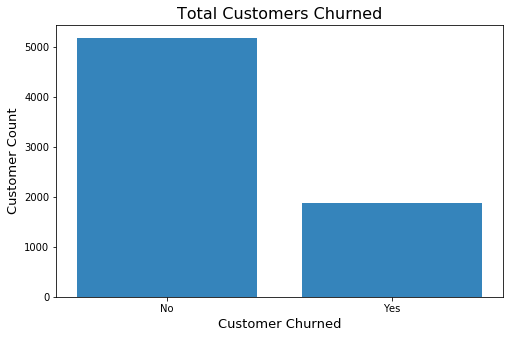

In [7]:
#Count target variable category instances
customer_data_target = customer_data.copy().groupby('Churn')[['customerID']].count()
customer_data_target = customer_data_target.rename(columns= {'customerID': 'customers'})

#Plot target variable count
plt.figure(figsize= (8, 5))

x_axis = np.arange(len(customer_data_target.index))
x_labels = customer_data_target.index
y_axis = customer_data_target['customers']

plt.bar(x_axis, y_axis, tick_label= x_labels, alpha= 0.9)
plt.title('Total Customers Churned', size= 16)
plt.xlabel('Customer Churned', size= 13)
plt.ylabel('Customer Count', size= 13)
plt.show()

Target variable imbalanced.

In [8]:
#Convert SeniorCitizen from binary to categorical string values
customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

In [9]:
#Generate new dataframe with target variable values converted to binary values
customer_data_bin = customer_data.iloc[:, 1:].copy()
customer_data_bin['Churn'] = customer_data_bin['Churn'].map({'Yes': 1, 'No': 0})

#Generate new dataframe with all non-numerical variables converted to binary or categorical integer values
le = preprocessing.LabelEncoder()

def transform_label(series):
    
    if series.dtype == 'object':
        series = le.fit_transform(series)
    
    return series

customer_data_trans = customer_data_bin.copy().apply(lambda x: transform_label(x))
customer_data_trans

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 1                0               0             2   
1                 0                0               2             0   
2                 0                0               2             2   
3                 1                0               2             0   
4                 0                1               0             0   
...             ...              ...             ...           ...   
7038              2                0               2             0   
7039              2                1               0             2   
7040              1                0               2             0   
7041              2                1               0             0   
7042              0                1               2             0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                    0            0            0                0         0   
1                    2            0            0                0         1   
2                    0            0            0                0         0   
3                    2            2            0                0         1   
4                    0            0            0                0         0   
...                ...          ...          ...              ...       ...   
7038                 2            2            2                2         1   
7039                 2            0            2                2         1   
7040                 0            0            0                0         0   
7041                 0            0            0                0         0   
7042                 2            2            2                2         2   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                    1              2           29.85         29.85      0  
1                    0              3           56.95       1889.50      0  
2                    1              3           53.85        108.15      1  
3                    0              0           42.30       1840.75      0  
4                    1              2           70.70        151.65      1  
...                ...            ...             ...           ...    ...  
7038                 1              3           84.80       1990.50      0  
7039                 1              1          103.20       7362.90      0  
7040                 1              2           29.60        346.45      0  
7041                 1              3           74.40        306.60      1  
7042                 1              0          105.65       6844.50      0  

[7043 rows x 20 columns]

C:\Users\sash_\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


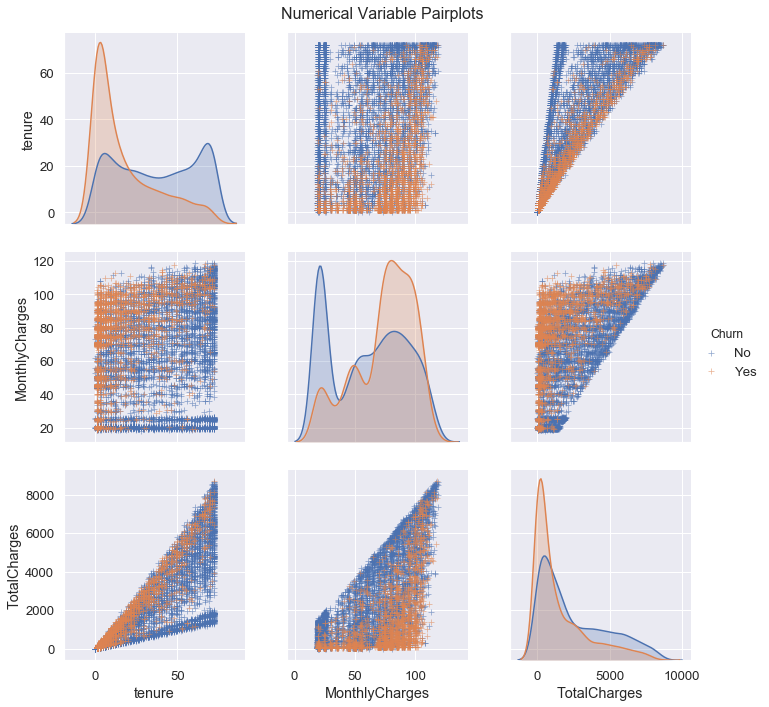

In [10]:
#Plot numerical variables and visualise churn values
sns.set(font_scale= 1.2)
g = sns.pairplot(customer_data[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']],
                 hue= 'Churn', markers= '+', plot_kws = {'alpha': 0.6}, size= 3.25);
g.fig.suptitle('Numerical Variable Pairplots', size= 16, y= 1.01);

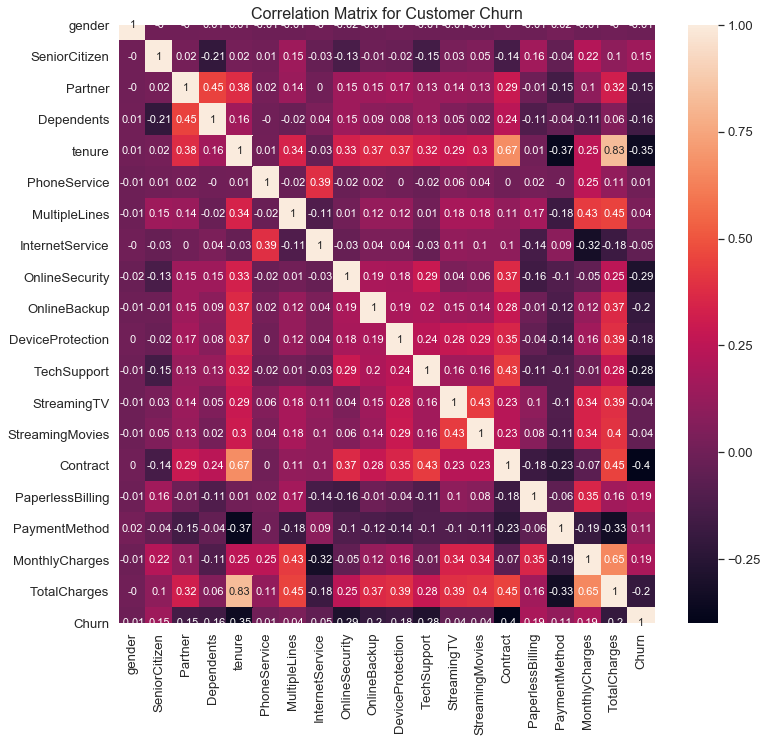

In [11]:
#Plot correlations on heatmap
plt.figure(figsize= (12, 11))
plt.title('Correlation Matrix for Customer Churn', size= 16)
sns.heatmap(round(customer_data_trans.corr(), 2), annot= True, annot_kws= {'size': 11});

Largest absolute correlation coefficients for churn appear to be tenure and Contract on the negative side and SeniorCitizen, PaperlessBilling and MonthlyCharges on positive side, although not very strong.

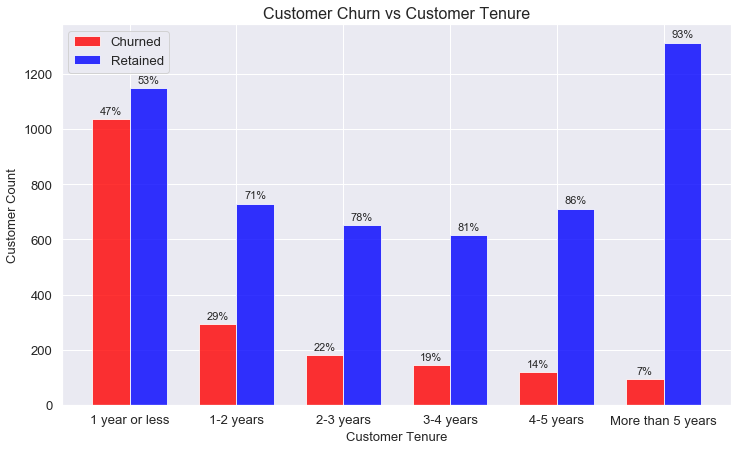

In [12]:
#Create dataframe with feature and target variable data
customer_stats = customer_data_trans[['Churn', 'tenure']].copy()

#Convert tenure from months to yearly categories with a function
def tenure_to_years(tenure):
    
    if tenure <= 1 * 12:
        return '1 year or less'
    elif tenure <= 2 * 12:
        return '1-2 years'
    elif tenure <= 3 * 12:
        return '2-3 years'
    elif tenure <= 4 * 12:
        return '3-4 years'
    elif tenure <= 5 * 12:
        return '4-5 years'
    else:
        return 'More than 5 years'

customer_stats['tenure'] = customer_stats['tenure'].apply(lambda x: tenure_to_years(x))

#Function to plot churn statistics on individual features
def plot_stats(stats_list):
    
    churn_count = customer_stats.copy().groupby(stats_list[0]).sum()
    total_count = customer_stats.copy().groupby(stats_list[0]).count()
    non_churn_count = total_count - churn_count

    fig, ax = plt.subplots(figsize= (12, 7))
    width = 0.35

    x_axis = np.arange(len(churn_count.index))
    x_labels = list(churn_count.index)
    y_axis_1 = churn_count['Churn']
    y_axis_2 = non_churn_count['Churn']
    bar_label_1 = 'Churned'
    bar_label_2 = 'Retained'

    churn_bar = ax.bar(x_axis - width/2, y_axis_1, width= width, label= bar_label_1, color= 'red', alpha= 0.8)
    non_churn_bar = ax.bar(x_axis + width/2, y_axis_2, width= width, label= bar_label_2, color= 'blue', alpha= 0.8)

    def bar_label(c_bars_1, c_bars_2):

        for bar_1, bar_2 in zip(c_bars_1, c_bars_2):

            height_1 = bar_1.get_height()
            height_2 = bar_2.get_height()
            fract_1 = height_1 / (height_1 + height_2)
            fract_2 = height_2 / (height_1 + height_2)

            ax.annotate('{:.0%}'.format(fract_1),
                        xy=(bar_1.get_x() + bar_1.get_width() / 2, height_1),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', size= 11)

            ax.annotate('{:.0%}'.format(fract_2),
                        xy=(bar_2.get_x() + bar_2.get_width() / 2, height_2),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', size= 11)

    bar_label(churn_bar, non_churn_bar)

    ax.set_title(stats_list[1], size= 16)
    ax.legend()
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(stats_list[2], size= 13)
    ax.set_ylabel('Customer Count', size= 13)
    plt.show()

stats_list = ['tenure', 'Customer Churn vs Customer Tenure', 'Customer Tenure']
plot_stats(stats_list)

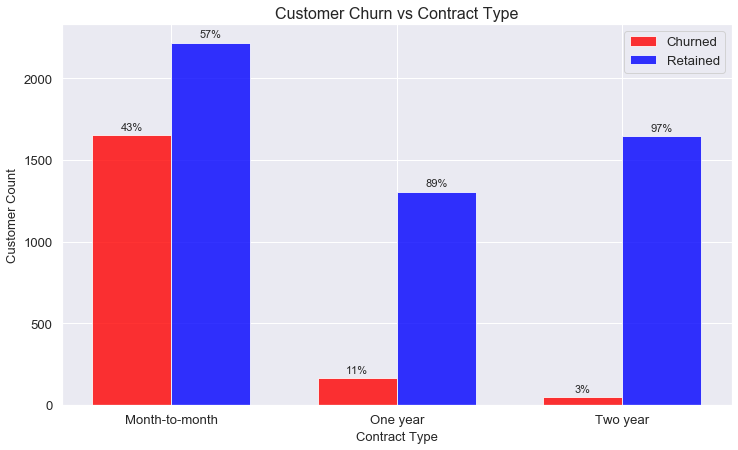

In [13]:
stats_list = ['Contract', 'Customer Churn vs Contract Type', 'Contract Type']
customer_stats = customer_data_bin[['Churn', stats_list[0]]].copy()

plot_stats(stats_list)

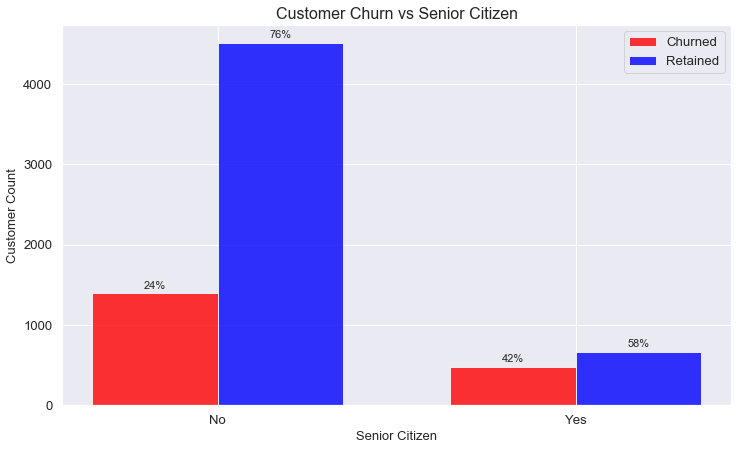

In [14]:
stats_list = ['SeniorCitizen', 'Customer Churn vs Senior Citizen', 'Senior Citizen']
customer_stats = customer_data_bin[['Churn', stats_list[0]]].copy()

plot_stats(stats_list)

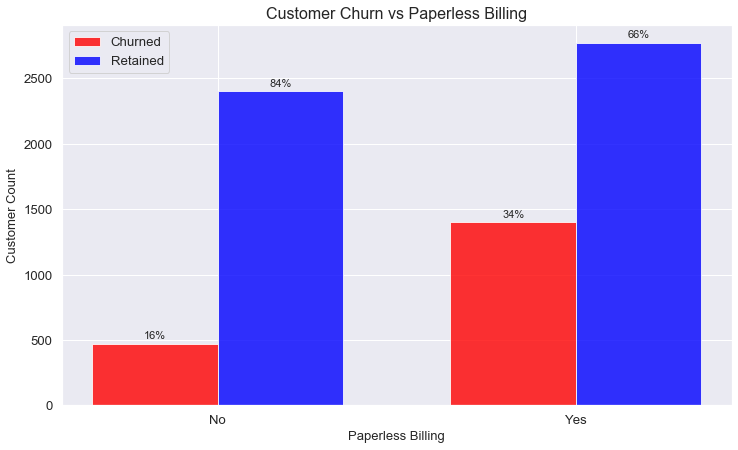

In [15]:
stats_list = ['PaperlessBilling', 'Customer Churn vs Paperless Billing', 'Paperless Billing']
customer_stats = customer_data_bin[['Churn', stats_list[0]]].copy()

plot_stats(stats_list)

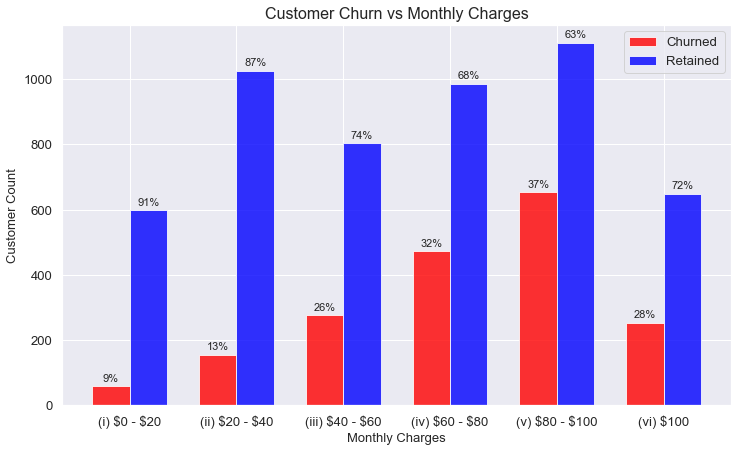

In [16]:
stats_list = ['MonthlyCharges', 'Customer Churn vs Monthly Charges', 'Monthly Charges']
customer_stats = customer_data_bin[['Churn', stats_list[0]]].copy()

def month_charge_categ(charges):
    
    if charges <= 1 * 20:
        return '(i) \$0 - $20'
    elif charges <= 2 * 20:
        return '(ii) \$20 - $40'
    elif charges <= 3 * 20:
        return '(iii) \$40 - $60'
    elif charges <= 4 * 20:
        return '(iv) \$60 - $80'
    elif charges <= 5 * 20:
        return '(v) \$80 - $100'
    elif charges > 5 * 20:
        return '(vi) \$100'

customer_stats[stats_list[0]] = customer_stats[stats_list[0]].apply(lambda x: month_charge_categ(x))

plot_stats(stats_list)

Try simple decision tree classifer on data to make preliminary assessment of model potential.

In [17]:
#Set up training and testing sets
features = customer_data_trans.copy().drop('Churn', axis= 1)
target = customer_data_trans['Churn'].copy()

skf = StratifiedKFold(n_splits= 5, shuffle= False, random_state= 2017)

In [31]:
#Set variables for iteration labels and calculation of metric averages
i = 1
train_score_tot = 0
test_score_tot = 0
precision_tot = 0
recall_tot = 0
F1_tot = 0

#Loop through each of the K folds 
for train_index, test_index in skf.split(features, target):
    #Fit model to current fold
    print('Fold %s of %s' % (i, skf.n_splits))
    i += 1
    
    features_train, features_test = features.iloc[train_index], features.iloc[test_index]
    target_train, target_test = target.iloc[train_index], target.iloc[test_index]
    
    dtc_trial = tree.DecisionTreeClassifier(random_state= 2017)
    dtc_trial.fit(features_train, target_train)
    
    #Print metric scores for current fold
    dtc_score_train = dtc_trial.score(features_train, target_train)
    print('Train score: ', dtc_score_train)

    dtc_score_test = dtc_trial.score(features_test, target_test)
    print('Test score: ', dtc_score_test)

    precision_score = metrics.precision_score(target_test, dtc_trial.predict(features_test))
    print('Precision score: ', precision_score)
    
    recall_score = metrics.recall_score(target_test, dtc_trial.predict(features_test))
    print('Recall score: ', recall_score)
    
    F1_score = metrics.f1_score(target_test, dtc_trial.predict(features_test))  
    print('F1 score: ', F1_score, '\n')
    
    #Print confusion matrix for current fold
    cm = metrics.confusion_matrix(target_test,dtc_trial.predict(features_test), labels= [1, 0])
    cm_index = pd.MultiIndex.from_tuples([('Actual', 'Churn'), ('Actual', 'Non-Churn')])
    cm_cols = pd.MultiIndex.from_tuples([('Predicted', 'Churn'), ('Predicted', 'Non-Churn')])
    cm_df = pd.DataFrame(cm, index= cm_index, columns= cm_cols)
    print('Confusion Matrix \n', cm_df, '\n\n')
    
    #Add score for current fold to cumulative sum for each metric
    train_score_tot += dtc_score_train
    test_score_tot += dtc_score_test
    precision_tot += precision_score
    recall_tot += recall_score
    F1_tot += F1_score

#Calculate and print mean scores for each metric
train_score_mean = train_score_tot / skf.n_splits
test_score_mean = test_score_tot / skf.n_splits
precision_mean = precision_tot / skf.n_splits
recall_mean = recall_tot / skf.n_splits
F1_mean = F1_tot / skf.n_splits

print('Mean train score: ', train_score_mean)
print('Mean test score: ', test_score_mean)
print('Mean precision score: ', precision_mean)
print('Mean recall score: ', recall_mean)
print('Mean F1 score: ', F1_mean)

Fold 1 of 5
Train score:  0.9978700745473909
Test score:  0.7444996451383961
Precision score:  0.5190217391304348
Recall score:  0.5106951871657754
F1 score:  0.5148247978436659 

Confusion Matrix 
                  Predicted          
                     Churn Non-Churn
Actual Churn           191       183
       Non-Churn       177       858 


Fold 2 of 5
Train score:  0.9973375931842385
Test score:  0.7288857345635202
Precision score:  0.48947368421052634
Recall score:  0.49732620320855614
F1 score:  0.49336870026525204 

Confusion Matrix 
                  Predicted          
                     Churn Non-Churn
Actual Churn           186       188
       Non-Churn       194       841 


Fold 3 of 5
Train score:  0.9984025559105432
Test score:  0.7196593328601846
Precision score:  0.47214854111405835
Recall score:  0.47593582887700536
F1 score:  0.474034620505992 

Confusion Matrix 
                  Predicted          
                     Churn Non-Churn
Actual Churn           

This classifier appears to be poor. Although our mean test accuracy is decent at above 70%, we can see for most of the folds that both precision and recall are below 50%. This means our accuracy mostly relates to correctly predicting the more numerous non-churn class or the true negatives, which is not what we're interested in. We want a model that will correctly predict our churning customers.

The problem with the classifer is that the model is overfitting on our training set. This is apparent as the training accuracy score is close to 100%. We'll need to add some constraining parameters to smooth the model and improve our classifier. I'm going to use a grid search to perform an exhaustive search over a set range for several parameters. This should help to generate an optimised model.

I'll start by running the grid search over each parameter separately to see if we can find a local optimal solution. I'll then use a narrower range for each parameter in a grid search that combines all of our parameters to try and find a global optimal solution. This is in order to reduce the computational cost of the grid search, which is a potential issue for a dataset even of this size.

The grid search model will use k-fold cross validation to split and train on the dataset and we will be using F1 score as the scoring criteria rather than ROC/AUC. This is because we have a binary classification model where the target variable is imbalanced.

As we saw with our trial run above, there are always a large number of True Negatives in our confusion matrix, which generally lowers our False Positive Rate. This will have the effect of inflating ROC/AUC scores. Recall is the most important measure in the case where you need to predict churn. If the cost of having many False Positives isn't too high for our company, we could just look to try and reasonably maximise recall. However, I am interested in having a good balance of precision and recall so will focus on F1 score.

In [73]:
#Define new function to fit model using GridSearchCV for the range of one individual parameter only
def grid_search(parameters, features, target):
    #Set up GridSearchCV using Decision Tree Classifer as underlying model
    gsc = GridSearchCV(estimator= tree.DecisionTreeClassifier(random_state= 2017),
                  param_grid= parameters, cv= skf, return_train_score= True, scoring= 'f1')
    
    #Print code start time to track computational cost 
    start_time = dt.now()
    print('Code start time: ', start_time)
    
    #Fit model to our dataset
    gsc.fit(features, target)
    gsc_results = gsc.cv_results_
    
    #Print code end time and execution time
    end_time = dt.now()
    print('Code end time: ', end_time)
    print('Code execution time: ', end_time - start_time, '\n')
    
    #Print model accuracy score, optimal parameter value and list of parameter values tested
    print('Best model accuracy score: ', gsc.best_score_)

    for key, value in gsc.best_params_.items():
        parameter_name = key
        parameter_value = value

    print('Best parameter: %s = %s' % (parameter_name, parameter_value))
    
    for key, value in gsc.param_grid.items():
        print ('Parameter values count: ', len(value))
        print ('Parameter values tested: \n', value)

    #Plot accuracy score over full range of parameter values tested
    gsc_results_df = pd.DataFrame(gsc_results)
    
    for key in params:
        parameter_df_name = str('param_' +  key)
    
    fig, ax = plt.subplots()
    ax.plot(gsc_results_df[parameter_df_name], gsc_results_df['mean_test_score']);
    ax.set_ylabel('F1 Score')
    ax.set_xlabel(parameter_df_name.replace('_', ' ').replace('param', '').title())
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

The first parameter to be tuned is maximum depth. We want to restrict the decision tree model from having too many layers of nodes. If not, it will have the effect of overfitting and fail to generalise the dataset properly. We'll try everything from 2 to 50 layers, although typically a good model for this dataset should probably sit below 10 layers given the number of features.

I'm also going to switch off warnings as we will likely get some undefined F1 scores in this inital deep dive due to the wide net I am casting. As long as my final parameter value range is feasible, I am not concerned any undefined scores for now.

Code start time:  2019-12-17 15:56:36.520585
Code end time:  2019-12-17 15:56:44.953077
Code execution time:  0:00:08.432492 

Best model accuracy score:  0.5968556394489929
Best parameter: max_depth = 2
Parameter values count:  48
Parameter values tested: 
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


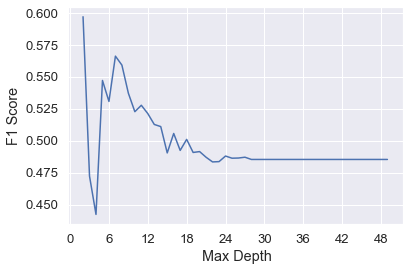

In [74]:
#Select parameter and range
params = {'max_depth': np.arange(2, 50)}

#Ignore warnings for undefined F1 scores
warnings.filterwarnings('ignore')

#Call GridSearchCV function on selected parameter values
grid_search(params, features, target)

#Reinstate warnings
warnings.filterwarnings('default')

As we suspected, the best max depth value is right at the bottom of the range we selected. The model works better when it is kept simple. A depth of only 2 suggests there may be a dominant variable in our feature set. The chart shows that there is also some promise around a max depth value of 7. Will will explore this area later when we combine our parameters.

Past this depth, we can see F1 scores drop off and eventually flatline, indicating there is probably some undefined scores beyond depth 26 or so.

Let's move on to our next parameter, which will be minimum samples split. We want to restrict this so that the classifier is not making splitting decisions on just a small number of observations. This would once again cause the model to overfit the data and fail to generalise the dataset properly. I'm going to try values from 10 up to 1,000, but this time in increments of 10. Otherwise the computational cost would be too high for my needs.

Code start time:  2019-12-17 15:56:45.201419
Code end time:  2019-12-17 15:56:56.770416
Code execution time:  0:00:11.568997 

Best model accuracy score:  0.5900706151848155
Best parameter: min_samples_split = 340
Parameter values count:  99
Parameter values tested: 
 [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540
 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720
 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900
 910 920 930 940 950 960 970 980 990]


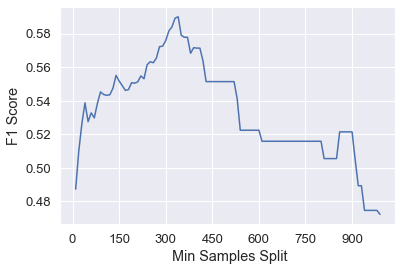

In [75]:
#Select parameter and range
params = {'min_samples_split': np.arange(10, 1000, 10)}

#Ignore warnings for undefined F1 scores
warnings.filterwarnings('ignore')

#Call GridSearchCV function on selected parameter values
grid_search(params, features, target)

#Reinstate warnings
warnings.filterwarnings('default')

This time we have landed on a value of 340, which is close to 5% of the observations of the entire dataset and even higher when using cross validation. We can see on the chart that the F1 score keeps rising all the way to 340, before quickly falling. This suggests there is strong local optimality to using this value.

Next up we will try different values of minimum samples leaf to restrict the number of observations at each leaf node at the bottom of our tree. This parameter will force the model to generalise to a certain degree. Like the other parameters it will cause us to learn less about our training data but will reduce the chance of overfitting.

I'm going to try values from 10 up to a value equal to 25% of the number of observations in the dataset, again in increments of 10 to reduce computational cost.

Code start time:  2019-12-17 15:56:57.002794
Code end time:  2019-12-17 15:57:12.060691
Code execution time:  0:00:15.057897 

Best model accuracy score:  0.5717793683195094
Best parameter: min_samples_leaf = 580
Parameter values count:  176
Parameter values tested: 
 [  10   20   30   40   50   60   70   80   90  100  110  120  130  140
  150  160  170  180  190  200  210  220  230  240  250  260  270  280
  290  300  310  320  330  340  350  360  370  380  390  400  410  420
  430  440  450  460  470  480  490  500  510  520  530  540  550  560
  570  580  590  600  610  620  630  640  650  660  670  680  690  700
  710  720  730  740  750  760  770  780  790  800  810  820  830  840
  850  860  870  880  890  900  910  920  930  940  950  960  970  980
  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120
 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260
 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400
 1410 1420 1430 1440 

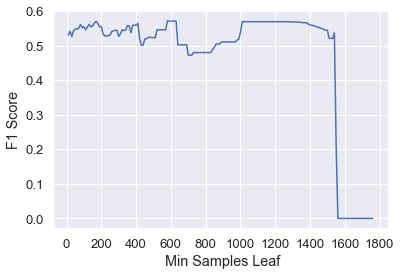

In [76]:
#Select parameter and range
params = {'min_samples_leaf': np.arange(10, round(len(features.index) / 4), 10)}

#Ignore warnings for undefined F1 scores
warnings.filterwarnings('ignore')

#Call GridSearchCV function on selected parameter values
grid_search(params, features, target)

#Reinstate warnings
warnings.filterwarnings('default')

The best parameter value in this case is 580. However, we can see on the chart of F1 scores that there appear to be 3 instances between a parameter value of 10 and 700 where we get a relatively high peak in F1 score. This parameter range is slightly hard to generalise. We may need to keep our range of values wide for our later model where we combine all of our parameters.

Finally, we'll test some different values for maximum features. This will restrict the number of possible features to be tested at each node for a split. This parameter is more important for bagging and random forests to ensure the trees are not highly correlated. However, we will still utilise the parameter as it will still reduce overfitting in a single tree.

Code start time:  2019-12-17 15:57:12.317971
Code end time:  2019-12-17 15:57:14.684970
Code execution time:  0:00:02.366999 

Best model accuracy score:  0.5001150291836646
Best parameter: max_features = 4
Parameter values count:  18
Parameter values tested: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


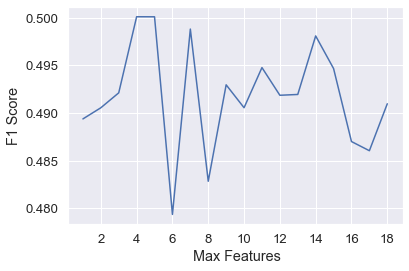

In [77]:
#Select parameter and range
params = {'max_features': np.arange(1, len(features.columns.tolist()))}
                                        
#Ignore warnings for undefined F1 scores
warnings.filterwarnings('ignore')

#Call GridSearchCV function on selected parameter values
grid_search(params, features, target)

#Reinstate warnings
warnings.filterwarnings('default')

In [25]:
params = {'max_depth': np.arange(2, 10),
          'min_samples_split': np.arange(300, 400, 10),
          'min_samples_leaf': np.arange(10, 700, 50),
          'max_features': np.arange(3, 9)
         }

gsc = GridSearchCV(estimator= tree.DecisionTreeClassifier(random_state= 2017),
                  param_grid= params, cv= skf, return_train_score= True, scoring= 'f1')

start_time = dt.now()
print('Code start time: ', start_time)

gsc.fit(features, target)

gsc_results = gsc.cv_results_

end_time = dt.now()
print('Code end time: ', end_time)
print('Code run time: ', end_time - start_time, '\n')

print('Best model accuracy score: ', gsc.best_score_)

def best_params (params, printout):
    params_list = ''
    
    if printout == 'Yes':
        print('Best model parameters: ')
    
        for param in params:
            print(param, '=', params[param])            
    else:
        for param in params:
            if len(params_list) == 0:
                params_list += str(str(param) + '=' + str(params[param]))
            else:
                params_list += str(', ' + str(param) + '=' + str(params[param]))
                
        return params_list
        
best_params(gsc.best_params_, 'Yes')

gsc_results_df = pd.DataFrame(gsc_results)
gsc_results_df.iloc[gsc.best_index_]

Code start time:  2019-12-17 14:14:32.394724
Code end time:  2019-12-17 14:21:45.145409
Code run time:  0:07:12.750685 

Best model accuracy score:  0.6148925769371831
Best model parameters: 
max_depth = 4
max_features = 7
min_samples_leaf = 10
min_samples_split = 300


mean_fit_time                                                     0.00737133
std_fit_time                                                     0.000495884
mean_score_time                                                   0.00199504
std_score_time                                                   1.75398e-05
param_max_depth                                                            4
param_max_features                                                         7
param_min_samples_leaf                                                    10
param_min_samples_split                                                  300
params                     {'max_depth': 4, 'max_features': 7, 'min_sampl...
split0_test_score                                                   0.625153
split1_test_score                                                   0.631961
split2_test_score                                                   0.605917
split3_test_score                                                   0.605985

In [27]:
params = {'max_depth': np.arange(2, 7),
          'min_samples_split': np.arange(290, 300),
          'min_samples_leaf': np.arange(1, 11),
          'max_features': np.arange(3, 9)
         }

gsc = GridSearchCV(estimator= tree.DecisionTreeClassifier(random_state= 2017),
                  param_grid= params, cv= skf, return_train_score= True, scoring= 'f1')

start_time = dt.now()
print('Code start time: ', start_time)

gsc.fit(features, target)

gsc_results = gsc.cv_results_

end_time = dt.now()
print('Code end time: ', end_time)
print('Code run time: ', end_time - start_time, '\n')

print('Best model accuracy score: ', gsc.best_score_)

def best_params (params, printout):
    params_list = ''
    
    if printout == 'Yes':
        print('Best model parameters: ')
    
        for param in params:
            print(param, '=', params[param])            
    else:
        for param in params:
            if len(params_list) == 0:
                params_list += str(str(param) + '=' + str(params[param]))
            else:
                params_list += str(', ' + str(param) + '=' + str(params[param]))
                
        return params_list
        
best_params(gsc.best_params_, 'Yes')

gsc_results_df = pd.DataFrame(gsc_results)
gsc_results_df.iloc[gsc.best_index_]

Code start time:  2019-12-17 14:36:49.082348
Code end time:  2019-12-17 14:40:20.237710
Code run time:  0:03:31.155362 

Best model accuracy score:  0.6148925769371831
Best model parameters: 
max_depth = 4
max_features = 7
min_samples_leaf = 1
min_samples_split = 290


mean_fit_time                                                     0.00778499
std_fit_time                                                     0.000739264
mean_score_time                                                   0.00418482
std_score_time                                                   0.000403171
param_max_depth                                                            4
param_max_features                                                         7
param_min_samples_leaf                                                     1
param_min_samples_split                                                  290
params                     {'max_depth': 4, 'max_features': 7, 'min_sampl...
split0_test_score                                                   0.625153
split1_test_score                                                   0.631961
split2_test_score                                                   0.605917
split3_test_score                                                   0.605985

In [28]:
print(gsc.param_grid)

{'max_depth': array([2, 3, 4, 5, 6]), 'min_samples_split': array([290, 291, 292, 293, 294, 295, 296, 297, 298, 299]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'max_features': array([3, 4, 5, 6, 7, 8])}


In [29]:
best_params_list = gsc.best_params_

dtc = tree.DecisionTreeClassifier(**best_params_list, random_state= 2017)
dtc.fit(features, target)

dtc_score_train = dtc.score(features, target)
print('Train score: ', dtc_score_train)

Train score:  0.7799233281272185


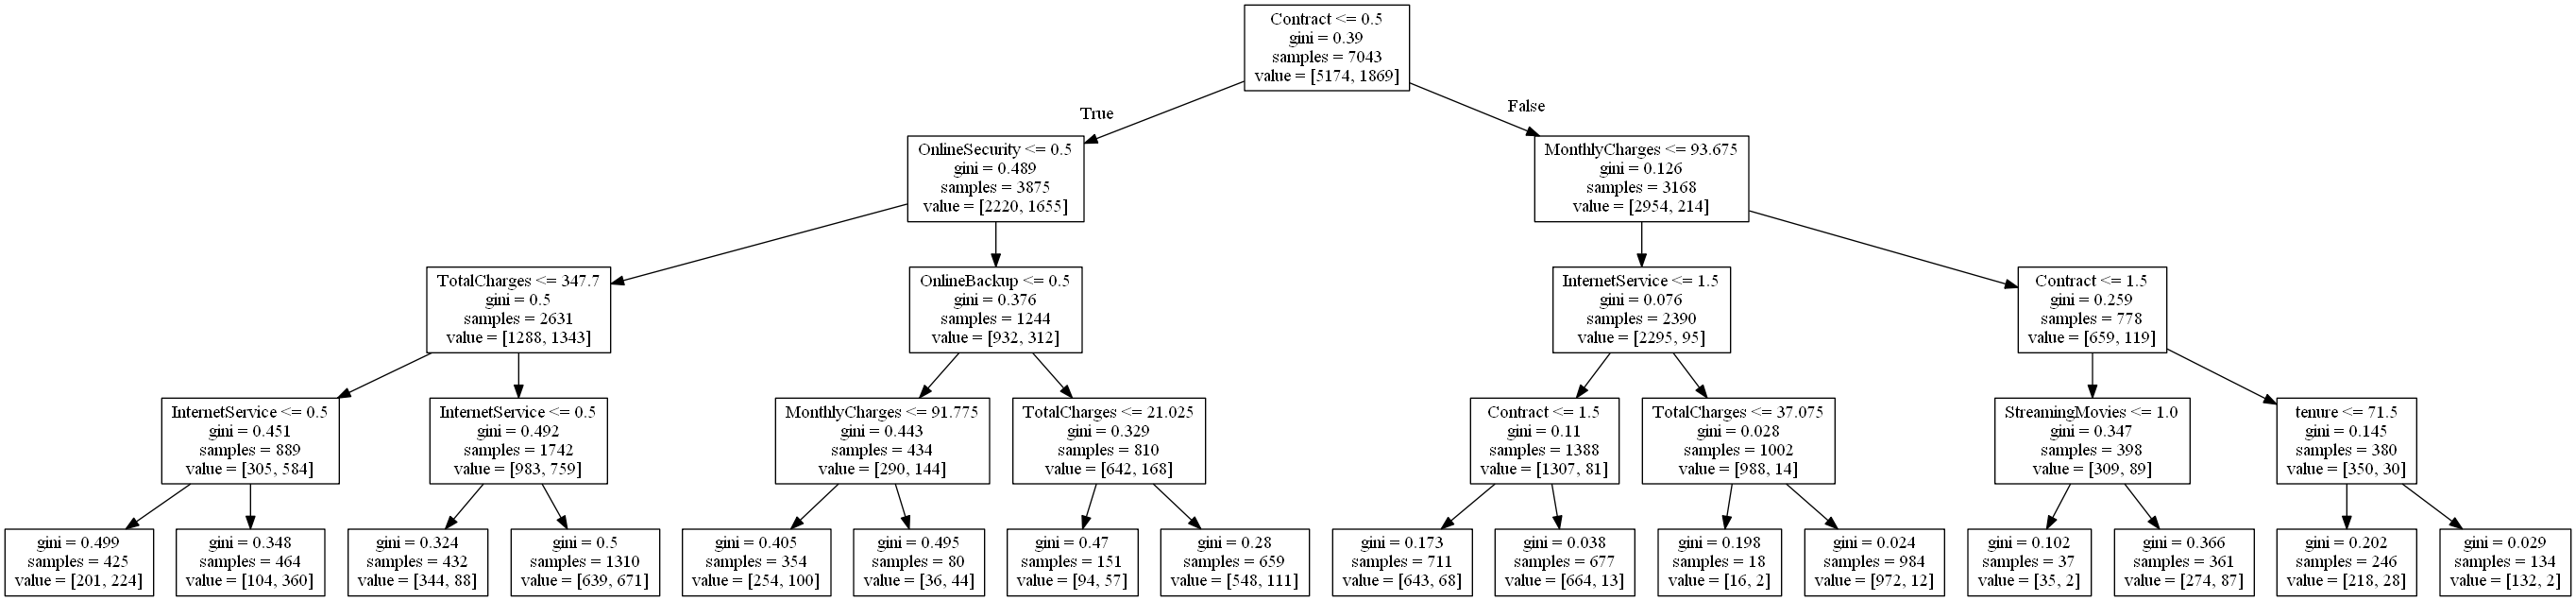

In [30]:
#Add some visualisation of the parameter df AUCs and accuracies and the decision tree
feature_list = features.columns.tolist()
out = StringIO()
tree.export_graphviz(dtc, out_file= out, feature_names= feature_list)

graph = pydotplus.graph_from_dot_data(out.getvalue())  
Image(graph.create_png())

In [33]:
feature_list = features.columns.tolist()
out = StringIO()
tree.export_graphviz(dtc_trial, out_file= out, feature_names= feature_list)

graph = pydotplus.graph_from_dot_data(out.getvalue())  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.562562 to fit



In [ ]:
plt.plot(gsc_results_df['param_max_depth'], gsc_results_df['mean_test_score'])

In [ ]:
#Export decision tree details to file
feature_list = features.columns.tolist()
tree.export_graphviz(dtc, out_file='tree_churn_analysis.dot', feature_names=feature_list)

In [ ]:
#Set up random forest classifier model and print accuracy score on test dataset
rfc = RandomForestClassifier(n_estimators= 100, max_features= 'auto', oob_score= True, random_state= 2017)
rfc.fit(features, target)
print('Out of bag accuracy: ', rfc.oob_score_)

In [ ]:
rf_importance = pd.DataFrame({'features': features.columns, 'importance': rfc.feature_importances_})
rf_importance.sort_values(by= 'importance', ascending= False, inplace= True)
rf_importance.head(5)

In [ ]:
#Using XGBoost
data_dmatrix = xgb.DMatrix(data= features, label= target)
xgbc = xgb.XGBClassifier(objective= 'reg:logistic', learning_rate= 0.05, colsample_bytree= 0.5, reg_lambda= 50)
xgbc.fit(features_train, target_train)

xgbc_score_train = xgbc.score(features_train, target_train)
print('Train score: ', xgbc_score_train)

xgbc_socre_test = xgbc.score(features_test, target_test)
print('Test score: ', xgbc_socre_test)